# Downloads


In [45]:
!git clone https://github.com/byaman14/ZS-SSL-PyTorch.git
%cd ZS-SSL-PyTorch
!pip install fastmri

Cloning into 'ZS-SSL-PyTorch'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 1), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 1.95 MiB | 37.05 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/ZS-SSL-PyTorch/ZS-SSL-PyTorch


# Utils

In [ ]:
import os
import h5py
import time
import numpy as np
import scipy.io as sio
import torch
import gc
from torch.utils.data import DataLoader
from models import utils, parser_ops, UnrollNet
from models.modules import MixL1L2Loss, Dataset, Dataset_Inference, train, validation, test
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
parser = parser_ops.get_parser()
args = parser.parse_args([])

# Data

In [46]:
dropbox_url_1 = "https://www.dropbox.com/scl/fi/o27mowrb7eg7weqc3osk0/file_brain_AXT2_210_6001944.h5?rlkey=khotlku9v43qwvf4c90e8wuvb&st=kgz2et2u&dl=0"
# Download the file
!wget -O brain.h5 $dropbox_url_1

--2024-12-12 03:27:01--  https://www.dropbox.com/scl/fi/o27mowrb7eg7weqc3osk0/file_brain_AXT2_210_6001944.h5?rlkey=khotlku9v43qwvf4c90e8wuvb
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7bf0e16ca2cfb6437140c70b1a.dl.dropboxusercontent.com/cd/0/inline/CgHuQhS9AfCkxyOaBMzCaGqnBAy96Qi6FNhmxMCKDbZv20rBrkDLFqckJXaiWsX-XKrl0xddTeMh7pxaNBSi-gbsPfFZSjg0KkeFANh3iIX6GZbOtYO7KLoIOsDbewirCxIkcBpE2y-b1I9xxZWbwe8a/file# [following]
--2024-12-12 03:27:02--  https://uc7bf0e16ca2cfb6437140c70b1a.dl.dropboxusercontent.com/cd/0/inline/CgHuQhS9AfCkxyOaBMzCaGqnBAy96Qi6FNhmxMCKDbZv20rBrkDLFqckJXaiWsX-XKrl0xddTeMh7pxaNBSi-gbsPfFZSjg0KkeFANh3iIX6GZbOtYO7KLoIOsDbewirCxIkcBpE2y-b1I9xxZWbwe8a/file
Resolving uc7bf0e16ca2cfb6437140c70b1a.dl.dropboxusercontent.com (uc7bf0e16ca2cfb6437140c70b1a.dl.dropboxusercontent.com)... 

In [47]:
args.data_dir = '/content/ZS-SSL-PyTorch/ZS-SSL-PyTorch/'
file = '/content/ZS-SSL-PyTorch/ZS-SSL-PyTorch/brain.h5'
hf = h5py.File(file, 'r')
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))
# USE THIS ONE INSTEAD: file_brain_AXT2_210_6001747.h5

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0007081719243083575, 'norm': 0.16223164878819385, 'patient_id': '9f1bb52e08717d5f753d9d076f101a7fd971d3f906c3ef8c318caad206891389'}


In [48]:
dropbox_url_2 = "https://www.dropbox.com/scl/fi/v6xszf8g6qys5vzregvol/my_brain0_smap_2.npy?rlkey=zy45jrhy0we2g8dwevhsrfu18&st=j6ko3z4v&dl=0"
!wget -O sensitivity.npy $dropbox_url_2

--2024-12-12 03:29:51--  https://www.dropbox.com/scl/fi/v6xszf8g6qys5vzregvol/my_brain0_smap_2.npy?rlkey=zy45jrhy0we2g8dwevhsrfu18
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe0ac89f275e4e8ba6eb0a137d.dl.dropboxusercontent.com/cd/0/inline/CgGTT9sYplgwzWtMs7q89l3C9bE9MhRxWTsBQDo5_VYSVqrIYPfJfz-kJ-9Lnq7mbsKrEjy9yBI1Rw3CWkHdF0cy00OFO_pWcxcSu85HyuZSjwg3eWtn9kKIHX-dz4u35ri8vA52ehcNEWfue4bMzqK0/file# [following]
--2024-12-12 03:29:52--  https://ucbe0ac89f275e4e8ba6eb0a137d.dl.dropboxusercontent.com/cd/0/inline/CgGTT9sYplgwzWtMs7q89l3C9bE9MhRxWTsBQDo5_VYSVqrIYPfJfz-kJ-9Lnq7mbsKrEjy9yBI1Rw3CWkHdF0cy00OFO_pWcxcSu85HyuZSjwg3eWtn9kKIHX-dz4u35ri8vA52ehcNEWfue4bMzqK0/file
Resolving ucbe0ac89f275e4e8ba6eb0a137d.dl.dropboxusercontent.com (ucbe0ac89f275e4e8ba6eb0a137d.dl.dropboxusercontent.com)... 162.125.8

In [50]:
# NEW SENSITVITY MAP
file_path = '/content/ZS-SSL-PyTorch/ZS-SSL-PyTorch/sensitivity.npy'
sensitivity_maps = np.load(file_path)
print("Loaded Sensitivity Maps shape:", sensitivity_maps.shape)

Loaded Sensitivity Maps shape: (16, 20, 768, 396)


# Setting up masks, maps, and kspace

In [51]:
def crop_center(data, crop_height, crop_width):
    # Get the original dimensions
    height, width = data.shape[-2], data.shape[-1]

    # Calculate cropping indices
    start_h = (height - crop_height) // 2
    end_h = start_h + crop_height
    start_w = (width - crop_width) // 2
    end_w = start_w + crop_width

    return data[..., start_h:end_h, start_w:end_w]

In [52]:
import numpy as np
sensitivity_maps_fft = np.fft.fftshift(np.fft.fft2(sensitivity_maps, axes=(-2, -1)), axes=(-2, -1))
print("Fourier Transformed and Shifted Sensitivity Maps shape:", sensitivity_maps_fft.shape)
crop_height, crop_width = 256, 132
sensitivity_maps_fft_cropped = crop_center(sensitivity_maps_fft, crop_height, crop_width)
print("Cropped Sensitivity Maps shape:", sensitivity_maps_fft_cropped.shape)
sensitivity_maps_cropped = np.fft.ifft2(np.fft.ifftshift(sensitivity_maps_fft_cropped, axes=(-2, -1)), axes=(-2, -1))
sensitivity_maps_cropped = np.abs(sensitivity_maps_cropped)  # Take magnitude
print("Inverse Transformed (Cropped) Sensitivity Maps shape:", sensitivity_maps_cropped.shape)
sensitivity_maps_cropped = np.transpose(sensitivity_maps_cropped, (0, 2, 3, 1))
print("Final Sensitivity Maps shape:", sensitivity_maps_cropped.shape)

Fourier Transformed and Shifted Sensitivity Maps shape: (16, 20, 768, 396)
Cropped Sensitivity Maps shape: (16, 20, 256, 132)
Inverse Transformed (Cropped) Sensitivity Maps shape: (16, 20, 256, 132)
Final Sensitivity Maps shape: (16, 256, 132, 20)


In [53]:
import numpy as np
slice_num = 7
crop_fraction = 1 / 3
kspace_permuted = np.transpose(hf['kspace'], (0, 2, 3, 1))
print("Permuted kspace shape:", kspace_permuted.shape)
kspace_single_slice = kspace_permuted[slice_num, :, :, :]
print("Original single slice kspace shape:", kspace_single_slice.shape)
crop_rows = int(kspace_single_slice.shape[0] * crop_fraction)
crop_cols = int(kspace_single_slice.shape[1] * crop_fraction)
row_start = (kspace_single_slice.shape[0] - crop_rows) // 2
row_end = row_start + crop_rows
col_start = (kspace_single_slice.shape[1] - crop_cols) // 2
col_end = col_start + crop_cols
cropped_kspace = kspace_single_slice[row_start:row_end, col_start:col_end, :]
print("Cropped kspace shape (complex):", cropped_kspace.shape)
sensitivity_maps = sensitivity_maps_cropped[slice_num, :, :, :]
print("Sensitivity maps shape:", sensitivity_maps.shape)
# Generate mask
# mask = np.ones((cropped_kspace.shape[0], cropped_kspace.shape[1]), dtype=np.float32)
# print("Mask shape:", mask.shape)

Permuted kspace shape: (16, 768, 396, 20)
Original single slice kspace shape: (768, 396, 20)
Cropped kspace shape (complex): (256, 132, 20)
Sensitivity maps shape: (256, 132, 20)


In [54]:
# MASK WITH ACCELERATION
from fastmri.data.subsample import EquispacedMaskFractionFunc
from fastmri.data import transforms as T
downsampling_func = EquispacedMaskFractionFunc(center_fractions=[0.04], accelerations=[2])
_ , mask, _ = T.apply_mask(T.to_tensor(np.transpose(cropped_kspace, (2, 0, 1))), downsampling_func)

In [55]:
mask_squeezed = mask.squeeze()
print("Squeezed Mask shape:", mask_squeezed.shape)
mask_repeated = mask_squeezed.repeat(256, 1)
print("Repeated Mask shape:", mask_repeated.shape)
mask = mask_repeated.numpy()
print("Mask shape (numpy):", mask.shape)

Squeezed Mask shape: torch.Size([132])
Repeated Mask shape: torch.Size([256, 132])
Mask shape (numpy): (256, 132)


In [56]:
data = {}
data['kspace'] = cropped_kspace
data['sens_maps'] = sensitivity_maps
data['mask'] = mask
print("Updated dictionary keys:", data.keys())
print(data['kspace'].shape)
print(data['sens_maps'].shape)
print(data['mask'].shape)

Updated dictionary keys: dict_keys(['kspace', 'sens_maps', 'mask'])
(256, 132, 20)
(256, 132, 20)
(256, 132)


In [57]:
kspace_train,sens_maps, original_mask= data['kspace'], data['sens_maps'], data['mask']
args.nrow_GLOB, args.ncol_GLOB, args.ncoil_GLOB  = kspace_train.shape
kspace_train= kspace_train / np.max(np.abs(kspace_train[:]))
kspace_train.shape

(256, 132, 20)

# Zero-Shot Self Supervised Sampling Functions

In [58]:
def norm(tensor, axes=(0, 1, 2), keepdims=True):
    """
    Parameters
    ----------
    tensor : It can be in image space or k-space.
    axes :  The default is (0, 1, 2).
    keepdims : The default is True.

    Returns
    -------
    tensor : applies l2-norm .

    """
    for axis in axes:
        tensor = np.linalg.norm(tensor, axis=axis, keepdims=True)

    if not keepdims: return tensor.squeeze()

    return tensor

def find_center_ind(kspace, axes=(1, 2, 3)):
    """
    Parameters

    ----------
    kspace : nrow x ncol x ncoil.
    axes :  The default is (1, 2, 3).

    Returns
    -------
    the center of the k-space

    """

    center_locs = norm(kspace, axes=axes).squeeze()

    return np.argsort(center_locs)[-1:]

def uniform_selection(input_data, input_mask, rho=0.2, small_acs_block=(4, 4)):

    nrow, ncol = input_data.shape[0], input_data.shape[1]

    center_kx = int(find_center_ind(input_data, axes=(1, 2)))
    center_ky = int(find_center_ind(input_data, axes=(0, 2)))

    temp_mask = np.copy(input_mask)
    temp_mask[center_kx - small_acs_block[0] // 2: center_kx + small_acs_block[0] // 2,
    center_ky - small_acs_block[1] // 2: center_ky + small_acs_block[1] // 2] = 0

    pr = np.ndarray.flatten(temp_mask)
    print("Shape of pr (flattened temp_mask):", pr.shape)
    print("Length of a (arange):", len(np.arange(nrow * ncol)))

    ind = np.random.choice(np.arange(nrow * ncol),
                            size=np.int(np.count_nonzero(pr) * rho), replace=False, p=pr / np.sum(pr))

    [ind_x, ind_y] = index_flatten2nd(ind, (nrow, ncol))

    loss_mask = np.zeros_like(input_mask)
    loss_mask[ind_x, ind_y] = 1

    trn_mask = input_mask - loss_mask

    return trn_mask, loss_mask


def index_flatten2nd(ind, shape):
    """
    Parameters
    ----------
    ind : 1D vector containing chosen locations.
    shape : shape of the matrix/tensor for mapping ind.

    Returns
    -------
    list of >=2D indices containing non-zero locations

    """

    array = np.zeros(np.prod(shape))
    array[ind] = 1
    ind_nd = np.nonzero(np.reshape(array, shape))

    return [list(ind_nd_ii) for ind_nd_ii in ind_nd]

# Deep Learning Prep

In [59]:
np.int = int
#..................Generate validation mask....................................
cv_trn_mask, cv_val_mask = uniform_selection(kspace_train,original_mask, rho=args.rho_val)
remainder_mask, cv_val_mask=np.copy(cv_trn_mask),np.copy(np.complex64(cv_val_mask))

#..............................validation data..................................
ref_kspace_val = np.empty((args.num_reps,args.nrow_GLOB, args.ncol_GLOB, args.ncoil_GLOB), dtype=np.complex64)
nw_input_val = np.empty((args.num_reps, args.nrow_GLOB, args.ncol_GLOB), dtype=np.complex64)

nw_input_val = utils.sense1(kspace_train * np.tile(cv_trn_mask[:, :, np.newaxis], (1, 1, args.ncoil_GLOB)),sens_maps)[np.newaxis]
ref_kspace_val=kspace_train*np.tile(cv_val_mask[:, :, np.newaxis], (1, 1, args.ncoil_GLOB))[np.newaxis]

print('size of kspace: ', kspace_train[np.newaxis,...].shape, ', maps: ', sens_maps.shape, ', mask: ', original_mask.shape)

Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
size of kspace:  (1, 256, 132, 20) , maps:  (256, 132, 20) , mask:  (256, 132)


<ipython-input-58-20a2186bf915>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_kx = int(find_center_ind(input_data, axes=(1, 2)))
<ipython-input-58-20a2186bf915>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_ky = int(find_center_ind(input_data, axes=(0, 2)))


In [60]:

#..............................train data.....................................
nw_input_trn = np.empty((args.num_reps, args.nrow_GLOB, args.ncol_GLOB), dtype=np.complex64)
ref_kspace = np.empty((args.num_reps, args.nrow_GLOB, args.ncol_GLOB, args.ncoil_GLOB), dtype=np.complex64)

trn_mask, loss_mask = np.empty((args.num_reps, args.nrow_GLOB, args.ncol_GLOB), dtype=np.complex64), \
                                np.empty((args.num_reps, args.nrow_GLOB, args.ncol_GLOB), dtype=np.complex64)

for jj in range(args.num_reps):
    trn_mask[jj, ...], loss_mask[jj, ...] = uniform_selection(kspace_train,remainder_mask, rho=args.rho_train)

    sub_kspace = kspace_train * np.tile(trn_mask[jj][..., np.newaxis], (1, 1, args.ncoil_GLOB))
    ref_kspace[jj, ...] = kspace_train * np.tile(loss_mask[jj][..., np.newaxis], (1, 1, args.ncoil_GLOB))
    nw_input_trn[jj, ...] = utils.sense1(sub_kspace,sens_maps)


<ipython-input-58-20a2186bf915>:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_kx = int(find_center_ind(input_data, axes=(1, 2)))
<ipython-input-58-20a2186bf915>:44: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_ky = int(find_center_ind(input_data, axes=(0, 2)))


Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange): 33792
Shape of pr (flattened temp_mask): (33792,)
Length of a (arange)

In [61]:
# %% Prepare the data for the training
sens_maps = np.tile(sens_maps[np.newaxis],(args.num_reps,1,1,1))
sens_maps = np.transpose(sens_maps, (0, 3, 1, 2))
ref_kspace = utils.complex2real(np.transpose(ref_kspace, (0, 3, 1, 2)))
nw_input_trn = utils.complex2real(nw_input_trn)

# %% validation data
ref_kspace_val = utils.complex2real(np.transpose(ref_kspace_val, (0, 3, 1, 2)))
nw_input_val = utils.complex2real(nw_input_val)

In [62]:
train_data= Dataset(nw_input_trn,trn_mask, loss_mask, sens_maps, ref_kspace)
train_loader = DataLoader(train_data, batch_size=args.batchSize, shuffle=True,num_workers = 6)

val_data = Dataset(nw_input_val,cv_trn_mask[np.newaxis], cv_val_mask[np.newaxis],  sens_maps[0][np.newaxis], ref_kspace_val)
val_loader = DataLoader(val_data, batch_size=args.batchSize, shuffle=False,num_workers = 6)

In [63]:
directory = os.path.join('saved_models', 'ZS_SSL_Model_'+str(args.epochs)+'Epochs_Rate'+ str(args.acc_rate) +\
                         '_' + str(args.nb_unroll_blocks) + 'Unrolls' )
if not os.path.exists(directory):
    os.makedirs(directory)

model =UnrollNet.UnrolledNet(args,device=device).to(device)
loss_fn = MixL1L2Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=args.learning_rate)

In [64]:
print(f"Using device: {device}")
# If a GPU is available, get its name
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU name: NVIDIA A100-SXM4-40GB


In [65]:
gc.collect()
torch.cuda.empty_cache()

# Train

In [ ]:
# FEEL FREE TO EXIT AFTER LOSS STOPS DECREASING, MAY HAVE TO CHANGE LEARING RATE IN PARAMS

total_train_loss,total_val_loss=[],[]
valid_loss_min = np.inf
ep, val_loss_tracker = 0, 0
#train the model
start_time=time.time()

model.train()

while ep<args.epochs and val_loss_tracker<args.stop_training:
  for batch_idx, data in enumerate(train_loader):
    print(f"Processing batch {batch_idx} in epoch {ep + 1}")


    tic = time.time()
    trn_loss, lamdas = train(train_loader, model, loss_fn, optimizer,device= device)
    val_loss = validation(val_loader, model, loss_fn, device= device)
    total_train_loss.append(trn_loss)
    total_val_loss.append(val_loss)

    #save the best checkpoint
    checkpoint = {
            "epoch": ep,
            "valid_loss_min":val_loss,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict()
        }
    if val_loss <= valid_loss_min:
        valid_loss_min = val_loss
        torch.save(checkpoint, os.path.join(directory,"best.pth"))
        val_loss_tracker = 0 #reset the val loss tracker each time a new lowest val error is achieved
    else:
        val_loss_tracker += 1

    toc = time.time() - tic
    if ep%10==0:
        print("Epoch:", ep+1, ", elapsed_time = ""{:f}".format(toc), ", trn loss = ", "{:.3f}".format(trn_loss),", val loss = ", "{:.3f}".format(val_loss))
    sio.savemat(os.path.join(directory, 'TrainingLog.mat'), {'trn_loss': total_train_loss, 'val_loss': total_val_loss})
    ep += 1

end_time = time.time()
print('Training completed in  ', str(ep), ' epochs, ',((end_time - start_time) / 60), ' minutes')


Processing batch 0 in epoch 1
Epoch: 1 , elapsed_time = 12.787106 , trn loss =  3537677.620 , val loss =  0.967
Processing batch 1 in epoch 2
Processing batch 2 in epoch 3
Processing batch 3 in epoch 4
Processing batch 4 in epoch 5
Processing batch 5 in epoch 6
Processing batch 6 in epoch 7
Processing batch 7 in epoch 8
Processing batch 8 in epoch 9
Processing batch 9 in epoch 10
Processing batch 10 in epoch 11
Epoch: 11 , elapsed_time = 12.533314 , trn loss =  1.001 , val loss =  0.967
Processing batch 11 in epoch 12
Processing batch 12 in epoch 13
Processing batch 13 in epoch 14
Processing batch 14 in epoch 15
Processing batch 15 in epoch 16
Processing batch 16 in epoch 17
Processing batch 17 in epoch 18
Processing batch 18 in epoch 19
Processing batch 19 in epoch 20


# Plot

In [ ]:
test_mask = np.complex64(original_mask)
#generate network input  and reference image
nw_input_inference = utils.sense1(kspace_train * np.tile(test_mask[..., np.newaxis], (1, 1, args.ncoil_GLOB)),np.transpose(sens_maps[0],(1,2,0)))
ref_image= utils.sense1(kspace_train,np.transpose(sens_maps[0],(1,2,0)))
'''if args.data_opt=='Coronal_PD' :
    test_mask[ :, 0:17] = np.ones((args.nrow_GLOB, 17))
    test_mask[:, 352:args.ncol_GLOB] = np.ones((args.nrow_GLOB, 16))'''

test_data = Dataset_Inference(utils.complex2real(nw_input_inference[np.newaxis]),test_mask[np.newaxis], test_mask[np.newaxis],  sens_maps[0][np.newaxis])
test_loader = DataLoader(test_data, batch_size=args.batchSize, shuffle=False,num_workers = 6)

In [ ]:
# directory = 'saved_models/ZS_SSL_Knee_Saved_Models_300Epochs_Rate4_10Unrolls'
# load the best checkpoint
best_checkpoint = torch.load(os.path.join(directory,'best.pth'))
model.load_state_dict(best_checkpoint["model_state"])
zs_ssl_recon = test(test_loader, model, device)
zs_ssl_recon = utils.real2complex(zs_ssl_recon.to('cpu').numpy())

<ipython-input-33-79674e29e23c>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_checkpoint = torch.load(os.path.join(directory,'best.pth'))


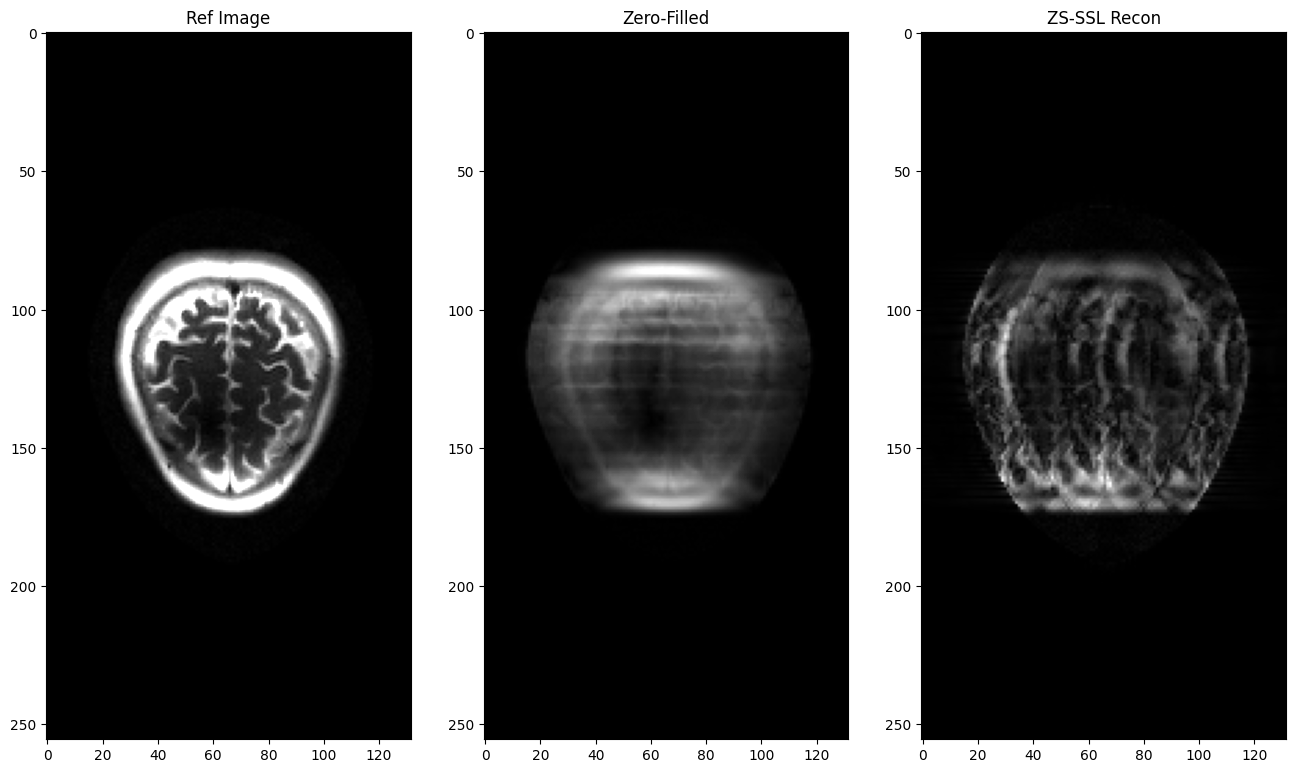

In [ ]:
if args.data_opt == 'Coronal_PD':
    """window levelling in presence of fully-sampled data"""
    factor = np.max(np.abs(ref_image[:]))
else:
    factor = 1

ref_image = np.abs(ref_image) / factor
nw_input_inference = np.abs(nw_input_inference) / factor
zs_ssl_recon = np.abs(zs_ssl_recon) / factor

plt.figure(figsize=(16,16))
plt.subplot(1,3,1),plt.imshow(ref_image,cmap='gray',vmax=0.6*np.max(ref_image[:])), plt.title('Ref Image')
plt.subplot(1,3,2),plt.imshow(nw_input_inference,cmap='gray',vmax=0.8*np.max(ref_image[:])), plt.title('Zero-Filled')
#plt.subplot(1,3,3),plt.imshow(zs_ssl_recon,cmap='gray',vmax=0.01*np.max(ref_image[:])), plt.title('ZS-SSL Recon')
plt.subplot(1,3,3),plt.imshow(zs_ssl_recon,cmap='gray'), plt.title('ZS-SSL Recon')
plt.show()

In [ ]:
print(f'min of reference image: {np.min(ref_image[:])} and max of reference image: {np.max(ref_image[:])}')
print(f'min of zero-filled image: {np.min(nw_input_inference[:])} and max of zero-filled image: {np.max(nw_input_inference[:])}')
print(f'min of recon image: {np.min(zs_ssl_recon[:])} and max of recon image: {np.max(zs_ssl_recon[:])}')

min of reference image: 4.001733936203466e-09 and max of reference image: 1.0
min of zero-filled image: 1.4811536494028903e-09 and max of zero-filled image: 0.8493465863221643
min of recon image: 2.9935752710319807e-09 and max of recon image: 0.03066199111812315


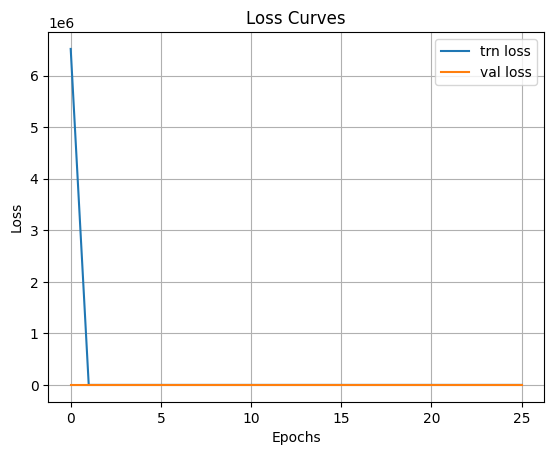

In [ ]:
plt.figure()
plt.plot(np.asarray(total_train_loss).T)
plt.plot(np.asarray(total_val_loss).T)
plt.title('Loss Curves'), plt.xlabel('Epochs'), plt.ylabel('Loss')
plt.legend(['trn loss', 'val loss'])
plt.grid()
plt.show()

# Save

Reconstruction saved at: reconstructions/acceleration_4/zs_ssl_recon.npy
Reconstruction plot saved at: reconstructions/acceleration_4/zs_ssl_recon_plot.png


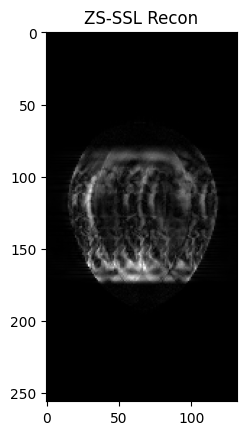

In [ ]:
acceleration = 4  # Replace with your acceleration value
save_dir = f"reconstructions/acceleration_{acceleration}"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "zs_ssl_recon.npy")
np.save(save_path, zs_ssl_recon)
print(f"Reconstruction saved at: {save_path}")
plt.imshow(zs_ssl_recon,cmap='gray')
plt.title('ZS-SSL Recon')
plot_path = os.path.join(save_dir, "zs_ssl_recon_plot.png")
plt.savefig(plot_path, dpi=650)
print(f"Reconstruction plot saved at: {plot_path}")

# Evaluation Functions

In [ ]:
import torch
from fastmri.data.subsample import *
from fastmri.data import transforms as T
import fastmri
from numpy import ndarray
from torchmetrics import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
from tqdm import tqdm

def normalize(not_norm):
    norm = (not_norm - not_norm.min()) / (not_norm.max() - not_norm.min())
    return norm

# @torch.compile
def mse(recon: torch.Tensor, gt: torch.Tensor) -> float:
    """Calculate the Mean Squared Error (MSE) between two MRI images.

    Args:
        recon (torch.Tensor): reconstructed image, 3D
            assumed structure (slice, coil, x, y)
        gt (torch.Tensor): ground truth image, 3D
            assumed structure (slice, coil, x, y)

    Returns:
        mse: the Mean Squared Errors (MSE) between the images
    """
    return torch.mean((recon - gt) ** 2)

def crop_center(data):
    dim_size = data.shape[1]
    dim_size2 = data.shape[2]
    center = int(dim_size/2)
    center2 = int(dim_size2/2)


    goal_size = int(data.shape[1]/2)
    d = int((dim_size-goal_size)/2)
    d2 = int(dim_size2-goal_size)/2

    new_data = data[:, center-d:center+d,center2-d2:center2+d2]
    return new_data


def crop_center(data):
    dim_size = data.shape[1]
    dim_size2 = data.shape[2]
    center = int(dim_size/2)
    center2 = int(dim_size2/2)
    goal_size = int(data.shape[1]/2)
    d = int((dim_size-goal_size)/2)
    d2 = int(dim_size2-goal_size)/2
    new_data = data[:, center-d:center+d,int(d2):int(dim_size2-d2)]

    return new_data
# @torch.compile
def psnr(recon: torch.Tensor, gt: torch.Tensor, pixel_max: float = 1) -> float:
    """Calculate the PSNR between two MRI images.

    Args:
        recon (torch.Tensor): reconstructed images, 3D
            assumed structure (slice, coil, x, y)
        gt (torch.Tensor): ground truth images, 3D
            assumed structure (slice, coil, x, y)
        max (float): maximum possible pixel value in the images

    Returns:
        psnr: the Peak Signal-to-Noise Ratios (PSNR) between the images
    """
    pixel_max = 1
    return 10 * torch.log10(pixel_max**2/mse(recon, gt))

#@torch.compile

# Initialize SSIM
torch_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
def ssim(recon: torch.Tensor, gt: torch.Tensor) -> float:
    """Calculate the Structural Similarity Index (SSIM) between MRI images.

    Args:
        recon (torch.Tensor): reconstructed images, 3D
            assumed structure (slice, coil, x, y)
        gt (torch.Tensor): ground truth images, 3D
            assumed structure (slice, coil, x, y)

    Returns:s
        ssim: the Structural Similarity Indices (SSIM) between the images
    """
    # Compute SSIM
    score = torch_ssim(torch.unsqueeze(recon,0),torch.unsqueeze(gt,0))
    return score



def ssim_old(recon: torch.Tensor, gt: torch.Tensor) -> float:
    """Calculate the Structural Similarity Index (SSIM) between MRI images.

    Args:
        recon (torch.Tensor): reconstructed images, 3D
            assumed structure (slice, coil, x, y)
        gt (torch.Tensor): ground truth images, 3D
            assumed structure (slice, coil, x, y)

    Returns:s
        ssim: the Structural Similarity Indices (SSIM) between the images
    """
    u1 = torch.mean(recon)
    u2 = torch.mean(gt)
    s1 = torch.std(recon)
    s2 = torch.std(gt)
    s12 = torch.mean((recon - u1) * (gt - u2))
    dynamic_range = torch.log2(torch.max(recon))
    c1 = (0.01*dynamic_range)**2
    c2 = (0.03*dynamic_range)**2
    return (2 * u1 * u2 + c1) * (2 * s12 + c2) / ((u1 ** 2 + u2 ** 2 + c1) * (s1 ** 2 + s2 ** 2 + c2))

# @torch.compile
def evaluate(recon: torch.Tensor, gt: torch.Tensor, max: float = 0.002) -> dict:
    """Evaluate the quality of a reconstructed MRI image.

    Args:
        recon (torch.Tensor): reconstructed image, 3D
            assumed structure (slice, coil, x, y)
        gt (torch.Tensor): ground truth image, 3D
        max (float): maximum possible pixel value in the images
            assumed structure (slice, coil, x, y)

    Returns:
        dict: a dictionary containing the evaluation metrics
    """

    recon_ssim = recon.unsqueeze(0)
    gt_ssim = gt.unsqueeze(0)

    return mse(recon, gt), psnr(recon, gt, max), ssim(recon_ssim, gt_ssim)

def evaluate_pics(raw: list[ndarray], gt: list[ndarray], recon_func, accelerations: list[int] = [1,2,4,8]) -> dict:
    """Evaluate the quality of reconstructed MRI images for different accelerations.

    Args:
        raw (list[ndaray]): list of raw k_space images
            assumed structure (sample, slice, coil, row, col)
        gt (list[ndarray]): list of ground truth images
            assumed structure (sample, slice, coil, row, col)
            col length is half of raw col length
        accelerations (list[int]): list of accelerations
        recon_func (function): function that reconstructs images
            expected signature: recon_func(downsampled: ndarray, autocalibration: ndarray) -> torch.Tensor

    Returns:
        dict: a dictionary containing the loss for each evaluation metric for each acceleration
    """
    metrics = {'mse': [], 'psnr': [], 'ssim': []}
    for accel in accelerations:
        accel_metrics = np.array([0.0, 0.0, 0.0])
        downsampling_func = EquiSpacedMaskFunc(center_fractions=[0.04], accelerations=[accel])
        print("ACCELERATION")
        print(accel)
        for i, kspace in enumerate(raw):
            # subsample the k-space
            downsampled , mask, _ = T.apply_mask(T.to_tensor(kspace), downsampling_func)
            downsampled = downsampled[...,0] + 1j * downsampled[...,1]
            downsampled = downsampled.numpy()
            calib = kspace[...,kspace.shape[-1]//2-kspace.shape[-1]//50:kspace.shape[-1]//2+kspace.shape[-1]//50]
            # reconstruct k-space
            recon = recon_func(downsampled, calib)
            recon = torch.tensor(crop_center(recon))
            # reconstruct image
          #  recon = fastmri.complex_abs(fastmri.ifft2c(T.to_tensor(recon_kspace)))
           # recon = recon[...,recon.shape[-1]//4:recon.shape[-1]//4+recon.shape[-1]//2,:]
            recon = normalize(recon)
            gt[i] = normalize(gt[i])
            losses = evaluate(recon, gt[i])
            accel_metrics += losses
        accel_metrics /= len(raw)
        metrics['mse'].append(accel_metrics[0])
        metrics['psnr'].append(accel_metrics[1])
        metrics['ssim'].append(accel_metrics[2])
    return metrics


def evaluate_all(raw: list[ndarray], gt: list[ndarray], recon_func, accelerations: list[int] = [2,4,6,8]) -> dict:
    """Evaluate the quality of reconstructed MRI images for different accelerations.

    Args:
        raw (list[ndaray]): list of raw k_space images
            assumed structure (sample, slice, coil, row, col)
        gt (list[ndarray]): list of ground truth images
            assumed structure (sample, slice, coil, row, col)
            col length is half of raw col length
        accelerations (list[int]): list of accelerations
        recon_func (function): function that reconstructs images
            expected signature: recon_func(downsampled: ndarray, autocalibration: ndarray) -> torch.Tensor

    Returns:
        dict: a dictionary containing the loss for each evaluation metric for each acceleration
    """
    metrics = {'mse': [], 'psnr': [], 'ssim': []}
    fig, axs = plt.subplots(len(accelerations)+1, 1, figsize=(25,5))
    for j, accel in enumerate(accelerations):
        accel_metrics = np.array([0.0, 0.0, 0.0])
        downsampling_func = EquiSpacedMaskFunc(center_fractions=[0.04], accelerations=[accel])
        print("ACCELERATION")
        print(accel)
        for i, kspace in enumerate(raw):
            # subsample the k-space
            downsampled , mask, _ = T.apply_mask(T.to_tensor(kspace), downsampling_func)
            downsampled = downsampled[...,0] + 1j * downsampled[...,1]
            downsampled = downsampled.numpy()
            calib = kspace[...,kspace.shape[-1]//2-kspace.shape[-1]//50:kspace.shape[-1]//2+kspace.shape[-1]//50]
            # reconstruct k-space
            recon_kspace = recon_func(downsampled, calib)
            # reconstruct image
            recon = fastmri.complex_abs(fastmri.ifft2c(T.to_tensor(recon_kspace)))
            recon = fastmri.rss(recon, dim=1)
            recon = crop_center(recon)
            print(recon.shape, gt[i].shape)
            losses = evaluate(recon, torch.tensor(gt[i]))
            accel_metrics += losses

            if i == 2:
                plt.imsave('brain_grappa_{}.png'.format(accel),recon[8].numpy(), format='png',  cmap='gray',  dpi=600)
                axs[j].imshow(recon[8])
                axs[j].set_title(f'Acceleration: {accel}, MSE: {losses[0]}, PSNR: {losses[1]}, SSIM: {losses[2]}')
                axs[j].axis('off')
        axs[-1].imshow(gt[3][8])
        axs[-1].set_title('Ground Truth')
        accel_metrics /= len(raw)
        metrics['mse'].append(accel_metrics[0])
        metrics['psnr'].append(accel_metrics[1])
        metrics['ssim'].append(accel_metrics[2])
    fig.tight_layout()
    fig.suptitle('Reconstructions at different accelerations')
    return metrics



/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


# Evaluations

In [ ]:
recon_ssim = torch.from_numpy(zs_ssl_recon).unsqueeze(0).unsqueeze(0)
recon_ssim.shape
evaluate(torch.from_numpy(zs_ssl_recon), torch.from_numpy(ref_image))

(tensor(0.0250, dtype=torch.float64),
 tensor(16.0171, dtype=torch.float64),
 tensor(0.7752))